# Resolve the transcriptional boost in gastrulation erythroid maturation data 

This tutorial shows how to analyze RNA velocity using cellDancer, including: (1) model estimation, (2) deriving cell fates in embedding level, and (3) pseudotime estimation.
 
Our advantage of resolving the existing difficulty of predicting genes that have transcriptional boost mentioned by [Bergen et al.](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02414-y) will be shown as well.

In the gastrulation erythroid maturation data, we selected 12,329 cells with 2,000 genes from haemato-endothelial progenitors, blood progenitors 1/2, and erythroid 1/2/3. The embryonic days are selected from E7.0, E7.25, E7.5, E7.75, E8.0, E8.25, and E8.5.

## Import packages

To run the notebook locally, [Installation](installation.html) could be referred to install the environment and dependencies.

In [1]:
# import packages
import os
import sys
import glob
import pandas as pd
import math
import matplotlib.pyplot as plt
import celldancer as cd
import celldancer.plotting as cdplt
from celldancer.plotting import colormap

## Load velocity estimation result of 2,000 genes

To display the prediction in embedding space and to estimate pseudotime by using all genes, all the 2,000 genes have already been predicted and could be downloaded from [GastrulationErythroid_cellDancer_estimation.csv](link). The .csv file could be loaded by ```pandas.read_csv()```.

In [2]:
# load the prediction result of all genes
cellDancer_df_path = 'your_path/GastrulationErythroid_cellDancer_estimation.csv'
cellDancer_df=pd.read_csv(cellDancer_df_path)

## Coumpute and visualize the prediction in embedding space

The prediction in the embedding space could be calculated with ```celldancer.compute_cell_velocity.compute()```. If not specified, all genes in cellDancer_df will be used to calculate the prediction in the embedding space. Following the method of [velocyto](https://velocyto.org/velocyto.py/index.html) and [scVelo](https://scvelo.readthedocs.io/), we project the velocity vectors of the cells into the low-dimensional embedding space.

After the calculation, the predicted direction in the embedding space, i.e. columns 'velocity1' and 'velocity2' will be added to the original dataframe. ```celldancer.plotting.cell.scatter_cell()``` could be used to display the predicted direction in embedding space.

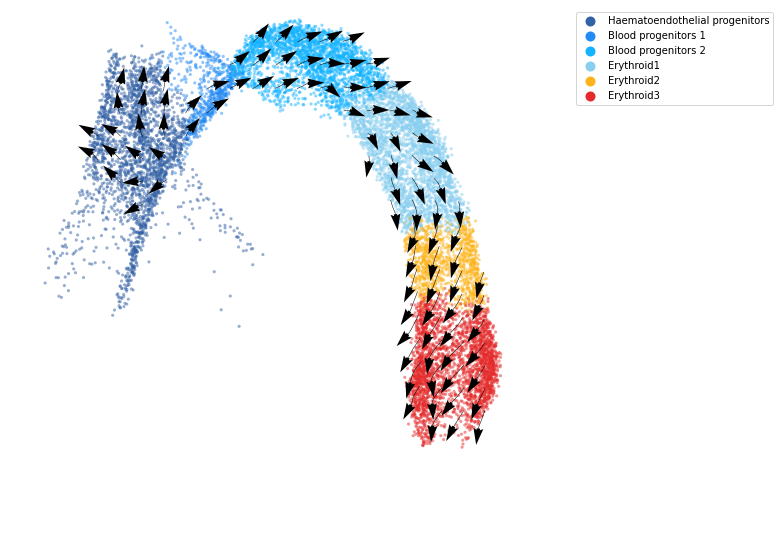

In [3]:
# compute cell velocity
cellDancer_df=cd.compute_cell_velocity.compute(cellDancer_df=cellDancer_df, projection_neighbor_choice='gene', expression_scale='power10', projection_neighbor_size=10, speed_up=(100,100))

# plot cell velocity
fig, ax = plt.subplots(figsize=(10,10))
cdplt.cell.scatter_cell(ax,
                        cellDancer_df, 
                        colors=cdplt.colormap.colormap_erythroid, 
                        alpha=0.5, 
                        s=10,
                        velocity=True,
                        legend='on',
                        min_mass=15,
                        arrow_grid=(20,20),
                        custom_xlim=[-6,13], 
                        custom_ylim=[2,16], )
ax.axis('off')
plt.show()

In [4]:
cellDancer_df

,cellIndex,gene_name,unsplice,splice,unsplice_predict,splice_predict,alpha,beta,gamma,loss,cellID,clusters,embedding1,embedding2,index,velocity1,velocity2
0,0,Ift81,0.010658,0.026321,0.009261,0.029549,0.023595,0.042598,0.073999,0.039626,cell_363,Blood progenitors 2,3.460521,15.574629,0,NaN,NaN
1,1,Ift81,0.000000,0.044266,0.000946,0.037888,0.020649,0.042942,0.074502,0.039626,cell_382,Blood progenitors 2,2.490433,14.971734,1,NaN,NaN
2,2,Ift81,0.000000,0.064559,0.000885,0.055191,0.019326,0.042876,0.075031,0.039626,cell_385,Blood progenitors 2,2.351203,15.267069,2,0.01257,-0.089692
3,3,Ift81,0.000000,0.020756,0.001014,0.017791,0.022149,0.043030,0.073879,0.039626,cell_393,Blood progenitors 2,5.899098,14.388825,3,NaN,NaN
4,4,Ift81,0.000000,0.013184,0.001037,0.011305,0.022633,0.043055,0.073676,0.039626,cell_398,Blood progenitors 2,4.823139,15.374831,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24657995,12324,Mcrip1,0.000000,1.128435,0.000157,1.125867,0.005920,0.038023,0.013131,0.051755,cell_139318,Erythroid3,8.032358,7.603037,12324,NaN,NaN
24657996,12325,Mcrip1,0.024356,0.970672,0.016090,1.428982,0.008338,0.037053,0.013950,0.051755,cell_139321,Erythroid3,10.352904,6.446736,12325,NaN,NaN
24657997,12326,Mcrip1,0.000000,0.899107,0.000175,0.897000,0.006575,0.037644,0.013522,0.051755,cell_139326,Erythroid3,9.464873,7.261099,12326,NaN,NaN
24657998,12327,Mcrip1,0.017375,1.398107,0.011387,1.729827,0.006885,0.037765,0.013271,0.051755,cell_139327,Erythroid3,9.990495,7.243880,12327,NaN,NaN


## Estimate Pseudotime

Based on the prediction in embedding space, the pseudotime could be estimated with ```celldancer.pseudo_time.pseudo_time()```.

In [5]:
%%capture

# set parameters
dt = 0.05
t_total = {dt:int(10/dt)} 
n_repeats = 10

# estimate pseudotime
cellDancer_df = cd.pseudo_time.pseudo_time(cellDancer_df=cellDancer_df, 
                                          grid=(20,20), 
                                          dt=dt, 
                                          t_total=t_total[dt], 
                                          n_repeats=n_repeats, 
                                          speed_up=(100,100),
                                          n_paths = 3,
                                          psrng_seeds_diffusion=[i for i in range(n_repeats)],
                                          activate_umap_paths_divider=False,
                                          n_jobs=8)

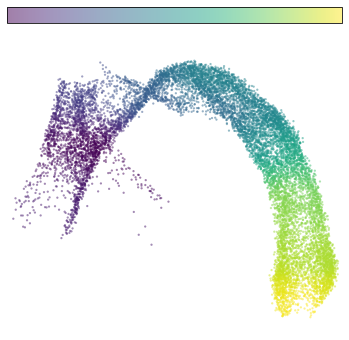

In [6]:
# plot pseudotime
fig, ax = plt.subplots(figsize=(6,6))
im=cdplt.cell.scatter_cell(ax,cellDancer_df, colors='pseudotime', alpha=0.5, velocity=False, custom_xlim=(-5,11), custom_ylim=(4,18))
ax.axis('off')
plt.show()

The connection network below is another way to display pseudotime. The edge lengths indicate the time difference between nodes (the closer in pseudotime, the shorter the edge length). The sizes of the nodes are proportional to the 
pseudotime.

## Pseudotime of gene

Let’s visualize the spliced RNA abundance of some sample genes based on pseudotime with ```celldancer.plotting.gene.scatter_gene()```.

In [7]:
ncols=5
height=math.ceil(len(gene_list)/ncols)*4
fig = plt.figure(figsize=(20,height))

for i in range(len(gene_list)):
    ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
    cdplt.gene.scatter_gene(
        ax=ax,
        x='pseudotime',
        y='splice',
        cellDancer_df=cellDancer_df,
        custom_xlim=None,
        custom_ylim=None,
        colors=colormap.colormap_erythroid,
        alpha=0.5, 
        s = 5,
        velocity=False,
        gene=gene_list[i])

    ax.set_title(gene_list[i])
    ax.axis('off')

NameError: name 'gene_list' is not defined